# 목차(TOC)

Author : HYGN

1. [데이터소개](#introduction)
2. [Load the data](#paragraph1)



## 데이터 소개<a name="introduction"></a>

[CreDB 개인신용 교육용DB(light)](https://www.findatamall.or.kr/fsec/dataProd/generalDataProdDetail.do?cmnx=44&goods_id=dafb9c70-ba89-11ea-9d5e-2d76f6f19fec) : 금융데이터거래소에서 무료로 다운로드 가능합니다.

1) CreDB 소개
  * 본 데이터는 신용정보원에 집중되는 신용정보를 표본추출한 뒤 비식별 조치하여 **통계 작성 및 학술 연구 목적**으로 이용자에게 제공하는 서비스입니다.

2) CreDB 교육용DB 소개
  * 실제 개인이 아닌 가상의 차주에 대한 **재현데이터(synthetic data)**입니다.
  * 개인정보 유출 위험없이 교육 및 실습 목적으로 활용 가능합니다.

3) DB설명
  * 가상의 신용거래차주 2,000명에 대한 '16.12월 ~ '18.12월 (25개월)동안의 대출/연체/카드개설정보.
  * (파일) `ID.csv(차주정보), LN.csv(대출정보), DLQ.csv(연체정보), CDOPN.csv(카드개설정보)`

## Import libraries


In [1]:
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.chdir("../../data/credb")

In [4]:
import glob
path = "./*.csv"
flist = glob.glob(path)
flist = sorted(flist)
flist

['./1. CREDB_P1_ID.csv',
 './2. CREDB_P1_LN.csv',
 './3. CREDB_P1_DLQ.csv',
 './4. CREDB_P1_CD_OPN.csv']

※ list에서 원본 list에 영향없이 정렬하고자 할 때, `sorted` 사용.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('ggplot')

## Load the Data <a name="paragraph1"></a>

### a.ID(차주정보)
  - join_key(차주일련번호) : 다른 데이터와 결합 key
  - bth_yr(생년) : 19세 이하 / 20~79세 / 80세 이상
  - gender(성별) : 남성(1) / 여성(2)

In [6]:
id_dat = pd.read_csv(flist[0],sep="|")
id_dat.head()

,JOIN_KEY,BTH_YR,GENDER
0,X0010254691714933659,1990,1
1,X0013455316779233219,1954,2
2,X0019385710745765957,1977,1
3,X0019442830801994941,1992,1
4,X0032015350750301834,1968,1


In [7]:
id_dat['GENDER'] = id_dat['GENDER'].astype('object')

In [8]:
id_dat.columns = id_dat.columns.str.lower()

In [9]:
print(np.min(id_dat['bth_yr']))
print(np.max(id_dat['bth_yr']))

1935
1999


In [10]:
id_dat.isnull().sum()

join_key    0
bth_yr      0
gender      0
dtype: int64

In [11]:
id_dat['join_key'].nunique()

2000

: 총 2,000명의 차주데이터입니다.

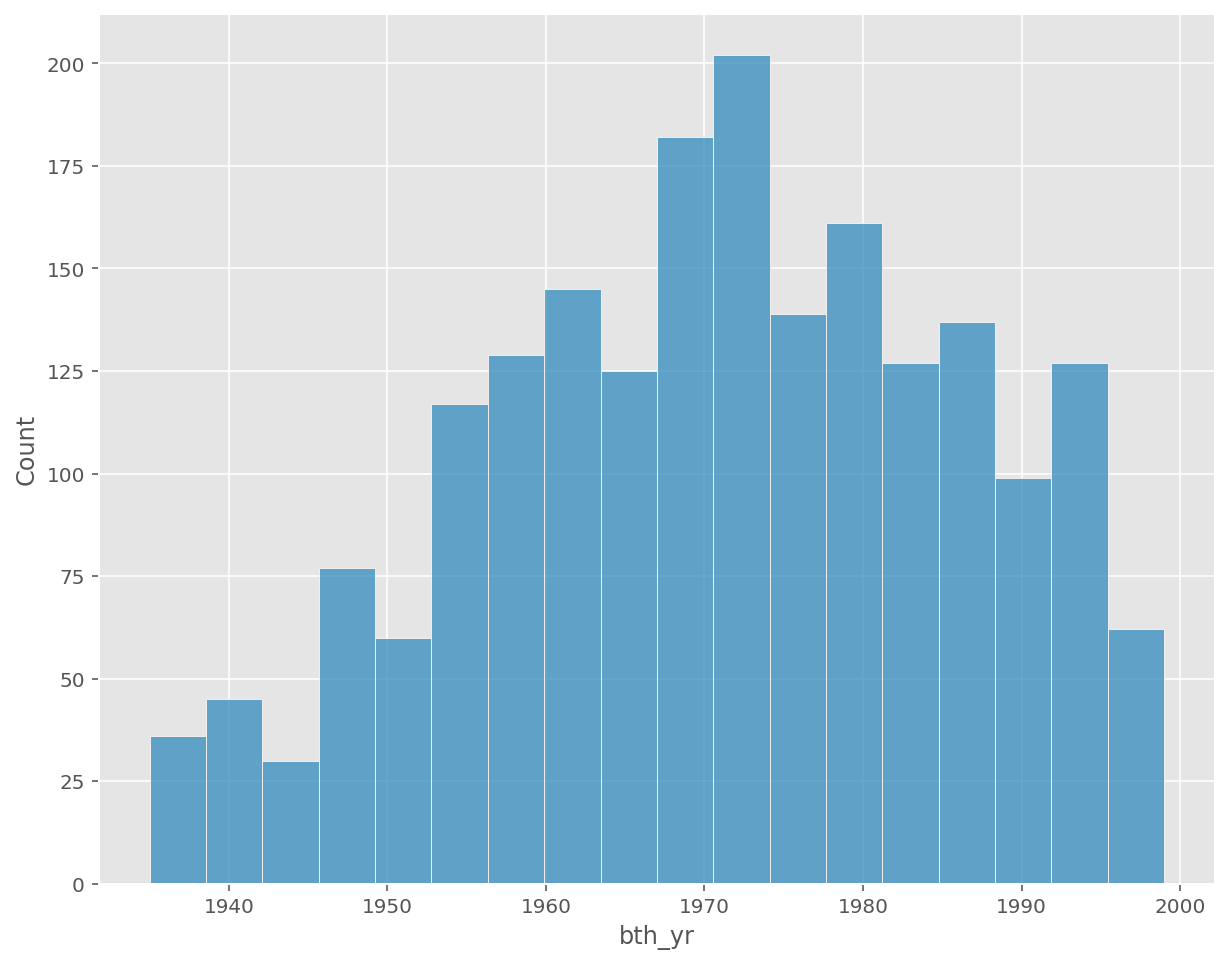

In [12]:
fig,ax = plt.subplots(figsize=(10,8))

sns.histplot(data=id_dat,x='bth_yr',stat='count')
plt.show()

In [13]:
id_dat['gender'].value_counts()

1    1094
2     906
Name: gender, dtype: int64

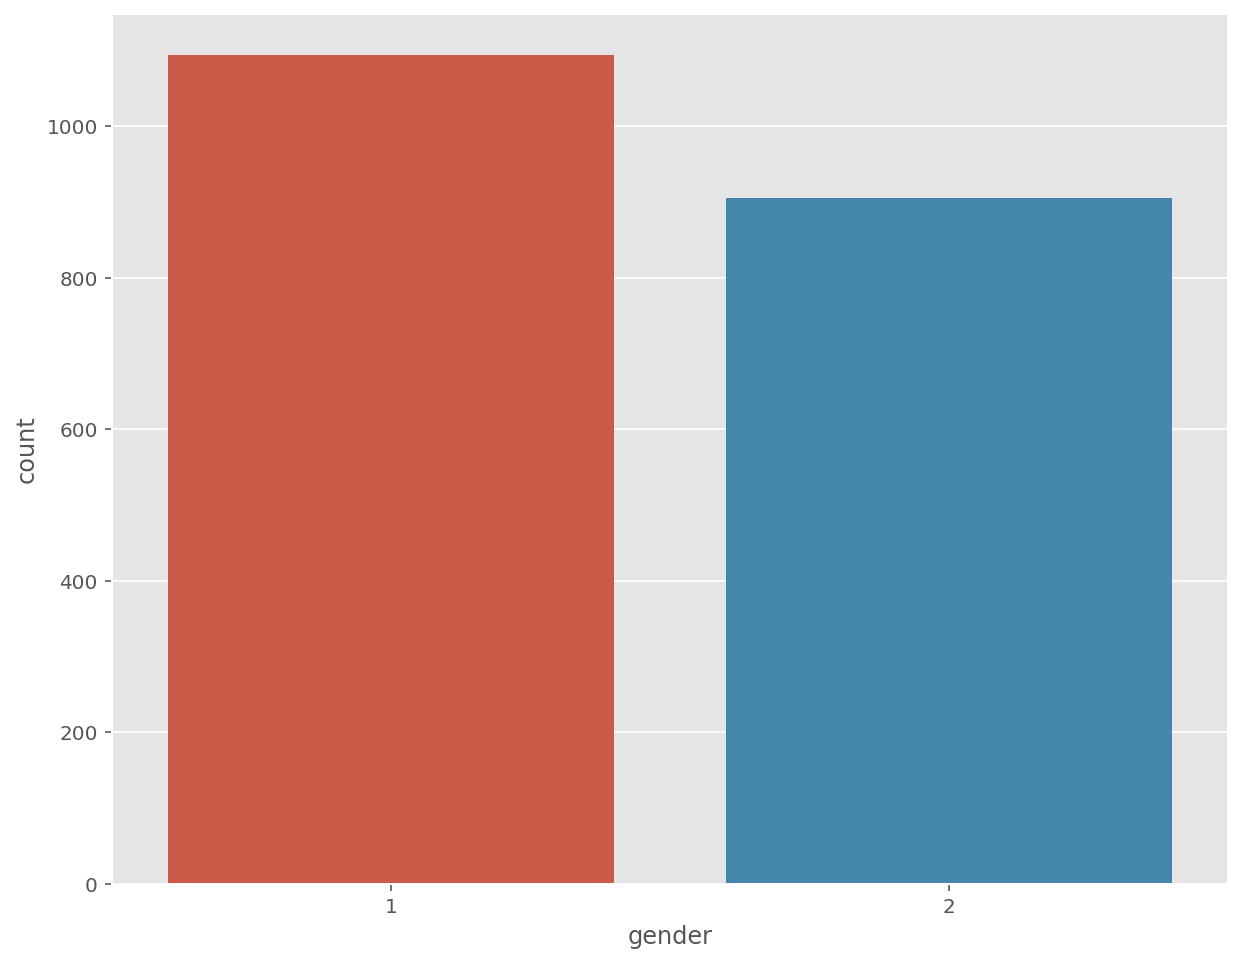

In [14]:
fig,ax = plt.subplots(figsize=(10,8))

sns.countplot(x='gender',data=id_dat)
plt.show()

## b.LN(대출정보)
  : 차주의 대출관련 정보를 대출기간 동안의 월말 snapshot 형태로 제공.
  
  : 예를 들어, 차주가 대출을 '17.1.15 ~ '17.5.15 동안 보유하고 있었다면 '17.1월말, 2월말, 3월말, 4월말 총 4개 시점의 정보를 제공.
 
 
  * ym(기준년월)
  * join_key(차주일련번호)
  * sctr_cd(업권코드) : 정보를 등록한 업권 구분코드(은행, 생보사, 손보사, 카드사, 캐피탈, 할부/리스/신기술사, 협동조합, 기타 등 8개)
  * com_key(기관일련번호) : 대출정보와 연체, 카드개설정보를 결합하기 위한 key
  * ln_cd_1(대출상품코드1) : 단기/장기 카드대출 등 대출상품구분
  * ln_cd_2(대출상품코드2) : 신용대출, 주택담보대출 등 대출상품구분
  * ln_ym(대출년월) : 대출정보가 등록된 년월
  * ln_amt(대출금액) : 기준월말 시점의 대출금액(단위: 천원) 

In [15]:
ln_dat = pd.read_csv(flist[1],sep="|")
ln_dat.head()

,YM,JOIN_KEY,SCTR_CD,COM_KEY,LN_CD_1,LN_CD_2,LN_YM,LN_AMT
0,201612,X0010254691714933659,1,X1363595463253465022,31,220,201610,19000
1,201612,X0010254691714933659,5,X2990775869667591539,41,0,201611,1000
2,201612,X0010254691714933659,1,X6048703495538110948,31,200,201612,10000
3,201612,X0010254691714933659,21,Y1605029911648266013,31,100,201604,5900
4,201701,X0010254691714933659,1,X1363595463253465022,31,220,201610,19000


In [16]:
ln_dat.columns = ln_dat.columns.str.lower()

In [17]:
ln_dat['ln_cd_2'] = ln_dat['ln_cd_2'].apply(lambda x : format(x,'003.0f'))

In [18]:
ln_dat['sctr_cd'] = ln_dat['sctr_cd'].astype('object') 
ln_dat['ln_cd_1'] = ln_dat['ln_cd_1'].astype('object') 
ln_dat['ln_cd_2'] = ln_dat['ln_cd_2'].astype('object') 

In [19]:
ln_dat['ln_cd'] = ln_dat['ln_cd_1'].astype('str') + ln_dat['ln_cd_2'].astype('str') 

In [20]:
ln_dat['join_key'].nunique()

1334

: 1,334명의 차주가 대출정보에 기록되어 있습니다.

In [21]:
# matplotlib 한글 폰트 출력코드
# 출처 : 데이터공방( https://kiddwannabe.blog.me)

import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False

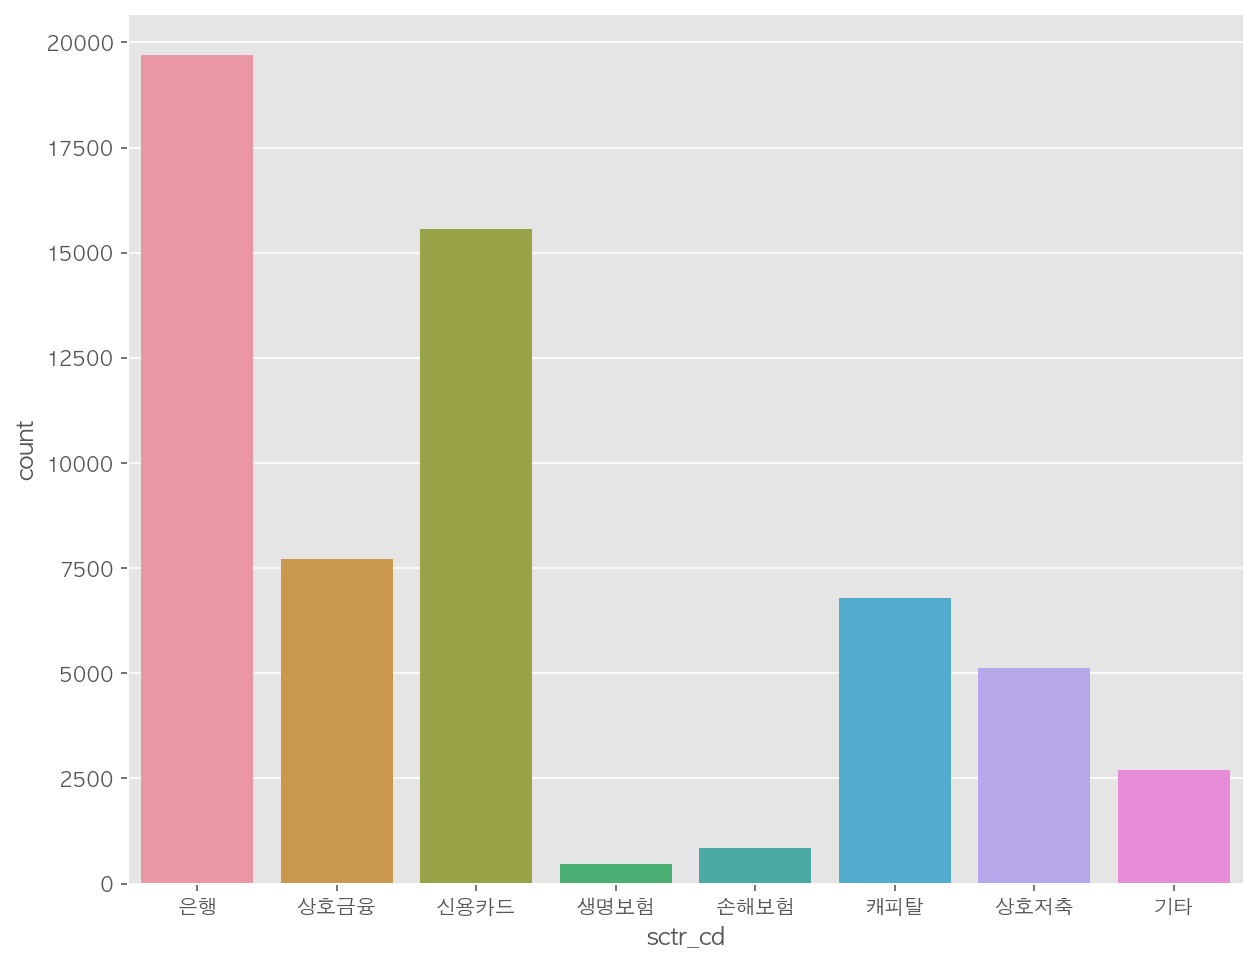

In [22]:
fig,ax = plt.subplots(1,figsize=(10,8))

sns.countplot(data=ln_dat,x='sctr_cd')
ax.set_xticklabels(['은행','상호금융','신용카드','생명보험','손해보험','캐피탈','상호저축','기타'])
plt.show()

* LN_CD

In [23]:
ln_dat['ln_cd_1'].value_counts()

31    42519
41     8389
37     8014
Name: ln_cd_1, dtype: int64

#### 방법 1. `pivot_table` 이용

In [24]:
ln_dat.pivot_table(index=['ln_cd_1','ln_cd_2'],values='join_key',aggfunc='count').reset_index()

,ln_cd_1,ln_cd_2,join_key
0,31,100,20320
1,31,150,1722
2,31,170,3
3,31,200,1608
4,31,210,472
5,31,220,7109
6,31,230,1617
7,31,240,2772
8,31,245,514
9,31,250,171


#### 방법 2. `groupby ` 이용.

In [25]:
ln_dat.groupby(by=['ln_cd_1','ln_cd_2'],as_index=False).agg({'join_key':'count'})

,ln_cd_1,ln_cd_2,join_key
0,31,100,20320
1,31,150,1722
2,31,170,3
3,31,200,1608
4,31,210,472
5,31,220,7109
6,31,230,1617
7,31,240,2772
8,31,245,514
9,31,250,171


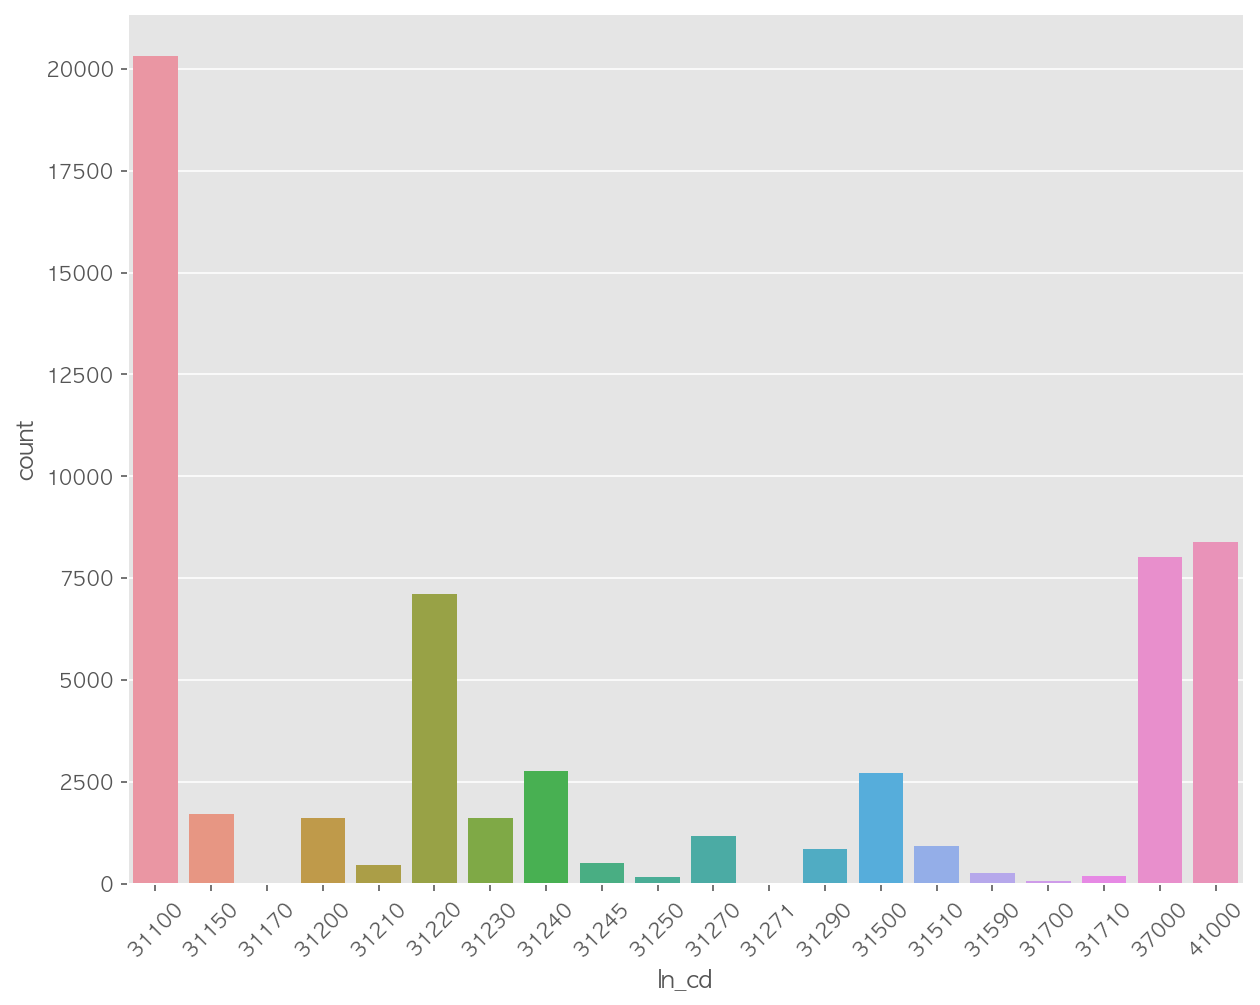

In [26]:
fig,ax = plt.subplots(figsize=(10,8))

sns.countplot(data=ln_dat.sort_values('ln_cd'),x='ln_cd')
plt.xticks(rotation=45)
plt.show()

: 신용대출, 단기카드대출, 장기카드대출, 주택담보대출 순으로 대출 건수가 많음.

* LN_AMT

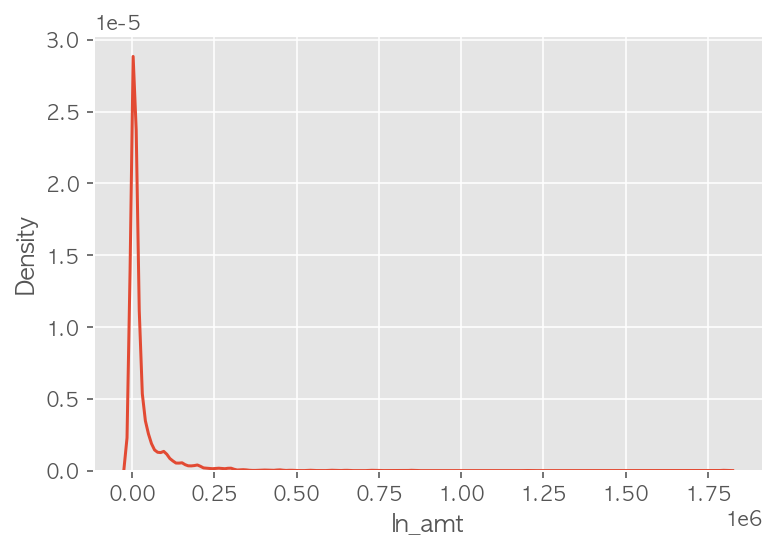

In [27]:
fig,ax
sns.kdeplot(data=ln_dat,x='ln_amt')
plt.show()

In [28]:
print("minimum : ",np.min(ln_dat['ln_amt'].unique()), 
      "\n","maximum : " ,format(np.max(ln_dat['ln_amt'].unique()),",d"))

minimum :  10 
 maximum :  1,800,000


* YM & LN_AMT

In [29]:
tmp1 = ln_dat.pivot_table(index=['ym'],columns=['ln_cd'],values='ln_amt',aggfunc='sum')

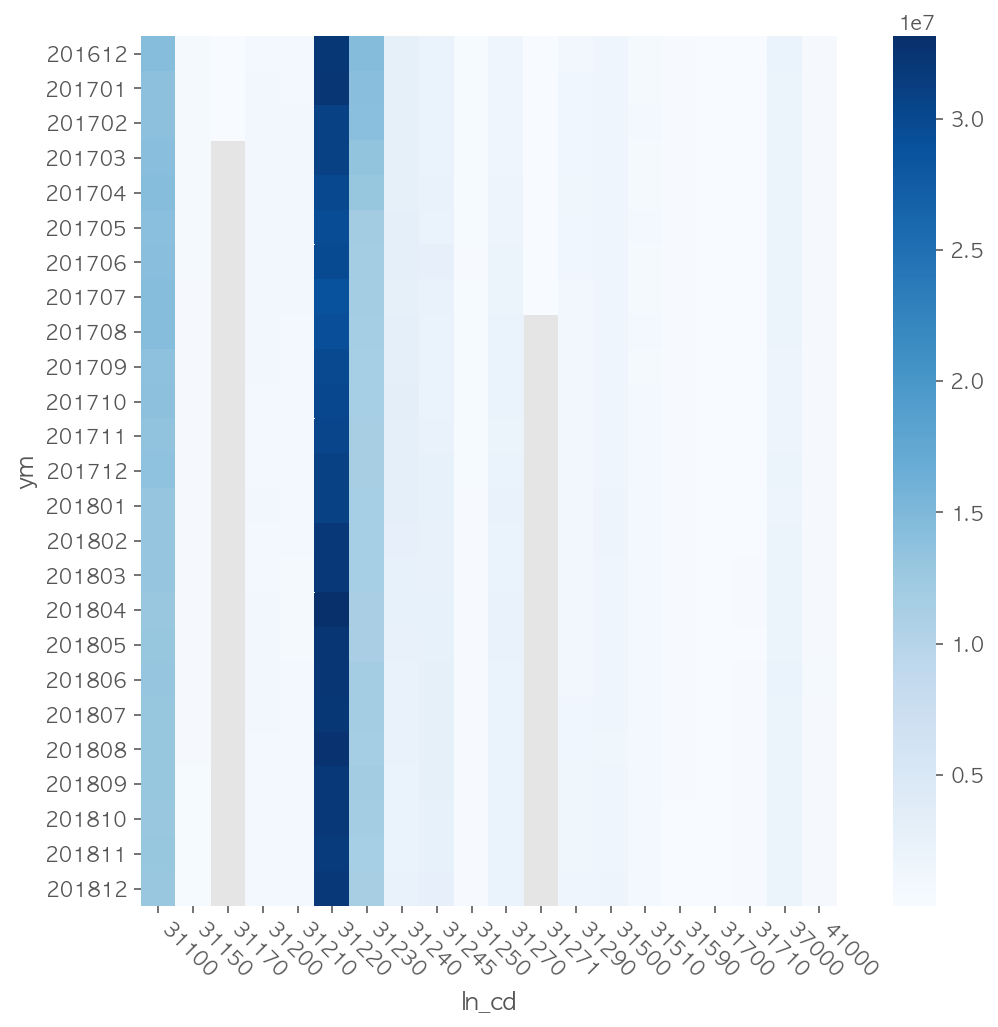

In [30]:
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(tmp1,cmap='Blues',square=True)
plt.xticks(rotation=315,ha='left')
plt.show()

## c.DLQ(연체정보)

In [31]:
dlq_dat = pd.read_csv(flist[2],sep="|")
dlq_dat.head()

,YM,JOIN_KEY,SCTR_CD,COM_KEY,DLQ_TYPE,DLQ_CD_1,DLQ_CD_2,DLQ_YM,DLQ_AMT
0,201801,X0010254691714933659,21,Y1605029911648266013,1,101,0,201801,5700
1,201802,X0010254691714933659,21,Y1605029911648266013,1,101,0,201801,5700
2,201612,X0214807498644962070,5,Y4755574378503849999,1,104,7,201611,900
3,201612,X0214807498644962070,98,Y9036878020951295900,1,101,0,201404,10000
4,201701,X0214807498644962070,5,Y4755574378503849999,1,104,7,201611,900


In [32]:
dlq_dat.columns = dlq_dat.columns.str.lower()

In [33]:
dlq_dat['sctr_cd'] = dlq_dat['sctr_cd'].astype('object') 
dlq_dat['com_key'] = dlq_dat['com_key'].astype('object') 

dlq_dat['dlq_type'] = dlq_dat['dlq_type'].astype('object') 
dlq_dat['dlq_cd_1'] = dlq_dat['dlq_cd_1'].astype('object') 
dlq_dat['dlq_cd_2'] = dlq_dat['dlq_cd_2'].astype('object') 

In [34]:
dlq_dat['dlq_cd_1'] = dlq_dat['dlq_cd_1'].apply(lambda x : format(x,'0004.0f'))

In [35]:
dlq_dat['dlq_cd_1'].unique()

array(['0101', '0104', '0202', '9997', '0103', '0201', '0199', '0299'],
      dtype=object)

In [36]:
dlq_dat['dlq_cd_2'].unique()

array([0, 7], dtype=object)

## d.CD_OPN(카드개설정보)

In [37]:
cd_dat = pd.read_csv(flist[3],sep="|")
cd_dat.head()

,YM,JOIN_KEY,COM_KEY,CD_OPN_CD_1,CD_OPN_CD_2,CD_OPN_YM
0,201612,X0010254691714933659,X0739620684726734804,81,1,201312
1,201612,X0010254691714933659,X2414244151238889690,81,1,200006
2,201612,X0010254691714933659,X2990775869667591539,81,1,201107
3,201612,X0010254691714933659,Y5029072213910072970,81,1,201511
4,201701,X0010254691714933659,X0739620684726734804,81,1,201312


In [38]:
cd_dat.columns = cd_dat.columns.str.lower()

In [39]:
cd_dat['ym'] = pd.to_datetime(cd_dat['ym'],format='%Y%m')
cd_dat['cd_opn_ym'] = pd.to_datetime(cd_dat['cd_opn_ym'],format='%Y%m')